# Example DRS Imager Processing

## Installation

In [72]:
# %pip install --upgrade pip setuptools wheel
# !git clone --branch implement_core_liger_datamodels https://github.com/oirlab/liger_iris_pipeline.git
# %pip install ./liger_iris_pipeline[test]
# !git clone --depth 1 https://github.com/oirlab/liger-iris-crds-cache $HOME/crds_cache

### CRDS configuraiton

In [73]:
from pathlib import Path
HOME = str(Path.home())
%set_env CRDS_PATH=$HOME/crds_cache
%set_env CRDS_CONTEXT=ligeriri_0001.pmap
%set_env CRDS_SERVER_URL="https://crds-serverless-mode.stsci.edu"
%set_env CRDS_INI_FILE=$HOME/crds_cache/crds.ini
%set_env CRDS_ALLOW_BAD_PARKEY_VALUES=1

env: CRDS_PATH=/Users/cale/crds_cache
env: CRDS_CONTEXT=ligeriri_0001.pmap
env: CRDS_SERVER_URL="https://crds-serverless-mode.stsci.edu"
env: CRDS_INI_FILE=/Users/cale/crds_cache/crds.ini
env: CRDS_ALLOW_BAD_PARKEY_VALUES=1


## Imports

In [74]:
import liger_iris_pipeline
from liger_iris_pipeline import datamodels
from liger_iris_pipeline.tests.utils import add_meta_data, download_osf_file
import numpy as np
import os
from astropy import units
import matplotlib.pyplot as plt
from textwrap import dedent

## Directories

In [75]:
output_dir = os.path.abspath("../../build/temp_output/") + os.sep
os.makedirs(output_dir, exist_ok=True)

## Level 0 &rarr; Level 1 (Ramp level corrections and fitting)

### Config

In [76]:
config = dedent("""\
class = "liger_iris_pipeline.Stage1Pipeline"

[steps]
    [[nonlinear_correction]]
        skip = False
    [[ramp_fit]]
        method = "ols"
""")
with open(output_dir + 'stage1.cfg', 'w') as f:
    f.write(config)

### Run Stage 1 Pipeline

In [77]:
# Imager data of Brown dwarf J1458+1013 in Y band.
sci_L0_filename = download_osf_file('IRIS/L0/2024B-P123-008_IRIS_IMG1_SCI-J1458+1013-Y-4.0_LVL0_0001-00.fits')
print(datamodels.open(sci_L0_filename).shape)
pipeline = liger_iris_pipeline.Stage1Pipeline(config_file=f'{output_dir}stage1.cfg')
results = pipeline.run(sci_L0_filename, output_dir=output_dir)
model_result = results[0] # Pipelines return a list of results
print(model_result.shape)

2025-03-25 15:19:15,867 - stpipe.Stage1Pipeline - INFO - Stage1Pipeline instance created.
2025-03-25 15:19:15,870 - stpipe.NonlinearCorrectionStep - INFO - NonlinearCorrectionStep instance created.
2025-03-25 15:19:15,870 - stpipe.FitRampStep - INFO - FitRampStep instance created.
2025-03-25 15:19:15,943 - stpipe.Stage1Pipeline - INFO - Step Stage1Pipeline parameters are:
  output_file: None
  output_dir: /Users/cale/Codes/liger_iris_pipeline/docs/build/temp_output/
  save_results: False
  skip: False
  suffix: None
2025-03-25 15:19:15,943 - stpipe.Stage1Pipeline - INFO - First argument /Users/cale/.astropy/cache/download/url/IRIS/L0/2024B-P123-008_IRIS_IMG1_SCI-J1458+1013-Y-4.0_LVL0_0001-00.fits does not appear to be a model
2025-03-25 15:19:15,955 - stpipe.Stage1Pipeline - INFO - Starting Stage 1 Pipeline ...
2025-03-25 15:19:15,956 - stpipe.Stage1Pipeline - INFO - Processing product /Users/cale/.astropy/cache/download/url/IRIS/L0/2024B-P123-008_IRIS_IMG1_SCI-J1458+1013-Y-4.0_LVL0_00

(101, 101, 1, 100)


2025-03-25 15:19:16,034 - stpipe.NonlinearCorrectionStep - INFO - Step NonlinearCorrectionStep parameters are:
  output_file: None
  output_dir: None
  save_results: False
  skip: False
  suffix: None
  nonlincoeff_ouput_dir: None
  nonlincoeff: None
2025-03-25 15:19:16,037 - CRDS - WARNING -  CRDS_SERVER_URL does not start with https://  :: "https://crds-serverless-mode.stsci.edu"
2025-03-25 15:19:16,171 - stpipe.NonlinearCorrectionStep - INFO - Using nonlincoeff reference file /Users/cale/crds_cache/references/ligeriri/iris/IRIS_IMG1_NONLINCOEFF_20240924T000000_0.0.1.fits
2025-03-25 15:19:16,202 - stpipe.NonlinearCorrectionStep - INFO - Results used CRDS context: ligeriri_0001.pmap
2025-03-25 15:19:16,203 - stpipe.NonlinearCorrectionStep - INFO - Step NonlinearCorrectionStep done
2025-03-25 15:19:16,272 - stpipe.FitRampStep - INFO - Step FitRampStep parameters are:
  output_file: None
  output_dir: None
  save_results: False
  skip: False
  suffix: None
  method: ols
  num_coadd: 3
2

(101, 101)


### Examine result

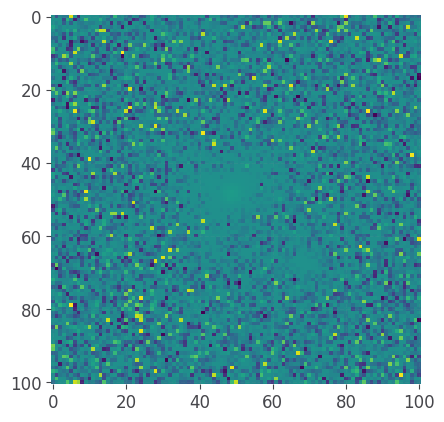

In [78]:
plt.imshow(model_result.data) # NOTE: Image is a smaller cutout of the original image, sky is still dominant signal here!

## Level 1 &rarr; Level 2 (Standard calibrations, WCS assignment)

### Config

In [79]:
config = dedent("""\
class = "liger_iris_pipeline.ImagerStage2Pipeline"
save_results = True

[steps]
    [[dark_sub]]
        skip = False
    [[flat_field]]
        skip = False
    [[sky_sub]]
    [[assign_wcs]]
        skip = False
""")

with open(output_dir + 'stage2_imager.cfg', 'w') as f:
    f.write(config)

In [80]:
sci_L1_filename = download_osf_file('IRIS/L1/2024B-P123-008_IRIS_IMG1_SCI-J1458+1013-Y-4.0_LVL1_0001-00.fits')
sky_L1_filename = download_osf_file('IRIS/L1/2024B-P123-008_IRIS_IMG1_SKY-J1458+1013-Y-4.0_LVL1_0001-00.fits')
asn = liger_iris_pipeline.L1Association.from_product({
    "members": [
        {
            "expname": sci_L1_filename,
            "exptype": "SCI",
        },
        {
            "expname": sky_L1_filename,
            "exptype": "SKY"
        }
    ]
})
pipeline = liger_iris_pipeline.ImagerStage2Pipeline(config_file=f'{output_dir}stage2_imager.cfg')
results = pipeline.run(asn, output_dir=output_dir)
model_result = results[0]

2025-03-25 15:19:16,413 - stpipe.ImagerStage2Pipeline - INFO - ImagerStage2Pipeline instance created.
2025-03-25 15:19:16,415 - stpipe.ParseSubarrayMapStep - INFO - ParseSubarrayMapStep instance created.
2025-03-25 15:19:16,415 - stpipe.DarkSubtractionStep - INFO - DarkSubtractionStep instance created.
2025-03-25 15:19:16,416 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2025-03-25 15:19:16,416 - stpipe.SkySubtractionImagerStep - INFO - SkySubtractionImagerStep instance created.
2025-03-25 15:19:16,416 - stpipe.AssignWCSStep - INFO - AssignWCSStep instance created.
2025-03-25 15:19:16,485 - stpipe.ImagerStage2Pipeline - INFO - Step ImagerStage2Pipeline parameters are:
  output_file: None
  output_dir: /Users/cale/Codes/liger_iris_pipeline/docs/build/temp_output/
  save_results: True
  skip: False
  suffix: None
2025-03-25 15:19:16,486 - stpipe.ImagerStage2Pipeline - INFO - First argument <liger_iris_pipeline.associations.association_base.L1Association object at 0x30d6

### Examine Results

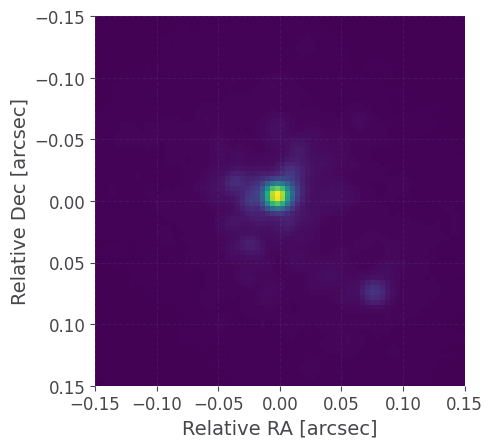

In [81]:
# Compute wcs corners
height, width = model_result.data.shape
corners = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]]) * units.pixel
world_corners = [model_result.meta.wcs(*corner) for corner in corners]
extent = [world_corners[0][0].value, world_corners[1][0].value, world_corners[2][1].value, world_corners[0][1].value]
dx = extent[1] - extent[0]
dy = extent[2] - extent[3]
extent = np.array([-dx / 2, dx / 2, dy / 2, -dy / 2]) * 3600

plt.imshow(model_result.data, extent=extent) # NOTE: Image is a full 4k x 4k image
plt.xlim(-0.15, 0.15); plt.ylim(0.15, -0.15)
plt.xlabel("Relative RA [arcsec]"); plt.ylabel("Relative Dec [arcsec]")
plt.show()

## Create a Flat Field Reference File

In [82]:
config = dedent("""\
class = "liger_iris_pipeline.CreateFlatfield"
save_results = True

[steps]
    [[dark_sub]]
    [[normalize]]
        method = "median"
""")

with open(output_dir + 'create_flat.cfg', 'w') as f:
    f.write(config)

In [83]:
# Create a simulated raw flat
raw_flat_model = datamodels.ImagerModel(data=np.random.normal(loc=1, scale=0.01, size=(4096, 4096)))
meta = {
    'model_type' : 'ImagerModel',
    'target.name': 'FLAT',
    'target.ra' : 0.0,
    'target.dec' : 0.0,
    'target.airmass_start' : 1.0,
    'exposure.itime' : 90,
    'exposure.nframes' : 1,
    'exposure.jd_start' : 2460577.5,
    'exposure.type' : 'FLAT',
    'instrument.name' : 'IRIS',
    'instrument.detector' : 'IMG1',
    'instrument.grating' : 'None',
    'instrument.mode' : 'IMG',
    'instrument.ifumode' : 'None',
    'instrument.filter' : 'Y',
    'instrument.scale' : 0.004,
}
add_meta_data(raw_flat_model, meta)
raw_flat_filename = raw_flat_model.generate_filename()
raw_flat_model.save(raw_flat_filename)

# Run the CreateFlatfield pipeline
pipeline = liger_iris_pipeline.CreateFlatfield(config_file=f'{output_dir}create_flat.cfg')
flat_model = pipeline.run(raw_flat_filename, output_dir=output_dir)

2025-03-25 15:19:17,751 - stpipe.CreateFlatfield - INFO - CreateFlatfield instance created.
2025-03-25 15:19:17,752 - stpipe.DarkSubtractionStep - INFO - DarkSubtractionStep instance created.
2025-03-25 15:19:17,753 - stpipe.NormalizeStep - INFO - NormalizeStep instance created.
2025-03-25 15:19:17,817 - stpipe.CreateFlatfield - INFO - Step CreateFlatfield parameters are:
  output_file: None
  output_dir: /Users/cale/Codes/liger_iris_pipeline/docs/build/temp_output/
  save_results: True
  skip: False
  suffix: None
2025-03-25 15:19:17,818 - stpipe.CreateFlatfield - INFO - First argument 2025A-P001-001_IRIS_IMG1_FLAT-FLAT-Y-0.004_LVL1_0001-00.fits does not appear to be a model
2025-03-25 15:19:17,818 - stpipe.CreateFlatfield - INFO - Starting Create flatfield ...
2025-03-25 15:19:17,854 - stpipe.CreateFlatfield - INFO - Processing 2025A-P001-001_IRIS_IMG1_FLAT-FLAT-Y-0.004_LVL1_0001-00.fits
2025-03-25 15:19:17,955 - stpipe.DarkSubtractionStep - INFO - Step DarkSubtractionStep parameters